# **Deep Neural Networks**

In this practice, we will work with a neural network composed of an input layer, 3 hidden layers, and an output layer.

- Overfitting / Underfitting
- Dropout
- Parameter Inicialization
- Early Stopping


In [ ]:
#@title Data and Imports

# General modules
import numpy as np
import pandas as pd

# Data processing modules
from torch.utils.data import random_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from torch.utils.data.dataloader import DataLoader
from sklearn.model_selection import train_test_split

# Plotting modules
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Dataset



Let's create a synthetic dataset to do the experiments. The *make_classification* function from the *sklearn.datasets* module is used to generate a synthetic dataset for classification tasks. The parameters passed to this function determine the characteristics of the dataset.

We will use a dataset composed of two classes and 1000 rows.

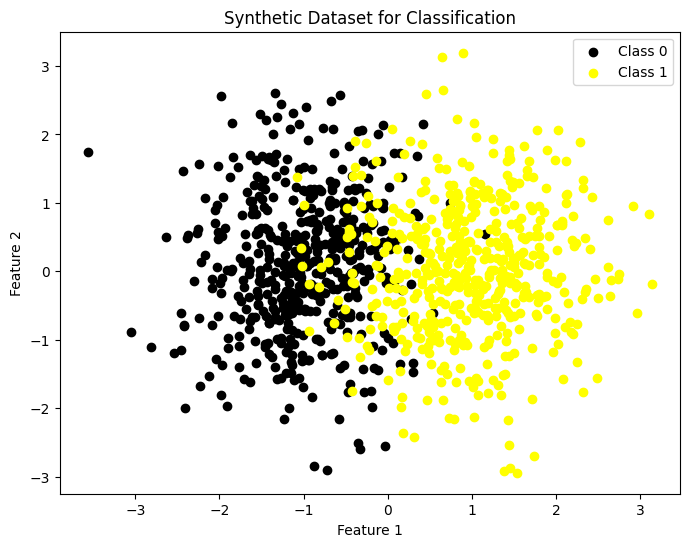

In [ ]:
X, y = make_classification(n_samples=1000, n_features=2, n_informative=1, n_redundant=0,
                           n_clusters_per_class=1, flip_y=0, class_sep=1, random_state=42)

# Plot the dataset
plt.figure(figsize=(8, 6))
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], c='black', marker='o', label='Class 0')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], c='yellow', marker='o', label='Class 1')
plt.title('Synthetic Dataset for Classification')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

In [ ]:
y = pd.get_dummies(y).values  # One-hot encode the target

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Deep Neural Network

In [ ]:
#@title Activation Functions

def sigmoid(x):
    # Clip values to avoid overflow
    x = np.clip(x, -500, 500)
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, x)

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

def relu_derivative(x):
    return (x > 0).astype(int)

In [ ]:
#@title Loss Function

def loss_function(y_true, y_pred):
  epsilon = np.finfo(float).eps
  return -np.mean(y_true * np.log(y_pred + epsilon))

def loss_function_derivative(y_true, y_pred):
    epsilon = np.finfo(float).eps
    return (y_pred - y_true) / (y_pred * (1 - y_pred) + epsilon)

In [ ]:
#@title Auxiliary Functions

def evaluate_accuracy(model, x, y):
    predictions = model.predict(x)
    accuracy = np.mean(np.argmax(predictions, axis=1) == np.argmax(y, axis=1))
    return accuracy

def plot_losses(all_losses):
    plt.figure(figsize=(10, 6))
    for i, fold_losses in enumerate(all_losses):
        plt.plot(range(1, len(fold_losses) + 1), fold_losses, label=f'Fold {i + 1}')

    average_losses = np.mean(all_losses, axis=0)
    plt.plot(range(1, len(average_losses) + 1), average_losses, label='Average', linewidth=2, color='black')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Losses Across Folds')
    plt.legend()
    plt.show()

def summary(model):
    # Return string
    summary = ''
    summary += "\nModel Architecture:\n"
    summary += "=" * 20 + "\n"
    summary += "{:<20} {:<20}\n".format("Layer Type", "Nº of Neurons")
    summary += "-" * 20 + "\n"
    summary += "{:<20} {:<20}\n".format("Input Layer", str(model.layer_sizes[0]))
    summary += "-" * 20 + "\n"
    for i in range(1, len(model.layer_sizes) - 1):
        summary += "{:<20} {:<20}\n".format("Hidden Layer " + str(i), str(model.layer_sizes[i]))
        summary += "-" * 20 + "\n"
    summary += "{:<20} {:<20}\n".format("Output Layer", str(model.layer_sizes[-1]))
    summary += "=" * 20 + "\n"

    return summary

# Auxiliary function to plot the decision boundary
def plot_decision_boundary(model, x):
    x_min, x_max = x[:, 0].min() - .5, x[:, 0].max() + .5
    y_min, y_max = x[:, 1].min() - .5, x[:, 1].max() + .5

    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = np.argmax(Z, axis=1)
    Z = Z.reshape(xx.shape)

    return xx, yy, Z

In [ ]:
#@title Neural Network

class DL_Model:
    def __init__(self, learning_rate, epochs, layer_sizes, dropout_prob=0):
        self.weights = {}
        self.biases = {}
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.layer_sizes = layer_sizes
        self.input_size = layer_sizes[0]
        self.output_size = layer_sizes[-1]
        self.dropout_prob = dropout_prob
        self.losses = []
        self.val_losses = []
        self.random_state = np.random.RandomState(42)

    def initialize_parameters(self):
        # Initialize weights and biases
        for i in range(len(self.layer_sizes) - 1):
            self.weights[i] = self.random_state.randn(self.layer_sizes[i], self.layer_sizes[i + 1])
            self.biases[i] = np.zeros((1, self.layer_sizes[i + 1]))

    def forward(self, x):
        # Forward pass
        self.activations = {}
        self.activations[0] = x
        for i in range(len(self.layer_sizes) - 1):
            self.activations[i + 1] = np.dot(self.activations[i], self.weights[i]) + self.biases[i]
            if i != len(self.layer_sizes) - 2:
                self.activations[i + 1] = relu(self.activations[i + 1])
            else:
                self.activations[i + 1] = sigmoid(self.activations[i + 1])

    def backward(self, y):
        # Backward pass
        self.gradients = {}
        loss_derivative = loss_function_derivative(y, self.activations[len(self.layer_sizes) - 1])
        self.gradients[len(self.layer_sizes) - 2] = loss_derivative
        for i in range(len(self.layer_sizes) - 2, 0, -1):
            self.gradients[i - 1] = np.dot(self.gradients[i], self.weights[i].T) * relu_derivative(self.activations[i])

    def clip_gradients(self):
        max_grad_norm = 1.0
        for i in range(len(self.layer_sizes) - 1):
            grad_norm = np.linalg.norm(self.gradients[i])
            if grad_norm > max_grad_norm:
                scale = max_grad_norm / (grad_norm + 1e-6)  # Avoid division by zero
                self.gradients[i] *= scale

    def update_parameters(self):
        # Update weights and biases
        self.clip_gradients()
        for i in range(len(self.layer_sizes) - 1):
            self.weights[i] -= self.learning_rate * np.dot(self.activations[i].T, self.gradients[i])
            self.biases[i] -= self.learning_rate * np.sum(self.gradients[i], axis=0, keepdims=True)

    def fit(self, x, y, validation_data=None):
        self.initialize_parameters()
        for _ in range(self.epochs):
            self.forward(x)
            self.backward(y)
            self.update_parameters()
            self.losses.append(loss_function(y, self.activations[len(self.layer_sizes) - 1]))

            x_val, y_val = validation_data
            self.forward(x_val)
            self.val_losses.append(loss_function(y_val, self.activations[len(self.layer_sizes) - 1]))
            print(f"\rEpoch:{_+1}, Loss:{self.losses[-1]:.4f}, Val Loss:{self.losses[-1]:.4f}",end="")

    def predict(self, x):
        self.forward(x)
        return self.activations[len(self.layer_sizes) - 1]

# Train and Predict

In [ ]:
#@title Hyperparameters initialization

input_size = x_train.shape[1]
output_size = y_train.shape[1]
hidden_layers = [512, 128, 32, 32]
layer_sizes = [input_size] + hidden_layers + [output_size]
learning_rate = 0.0001
epochs = 1000

In [ ]:
#@title Training

nn = DL_Model(learning_rate, epochs, layer_sizes)
nn.fit(x_train, y_train, validation_data=(x_val, y_val))

Epoch:1000, Loss:0.1177, Val Loss:0.1177

Accuracy: 0.915


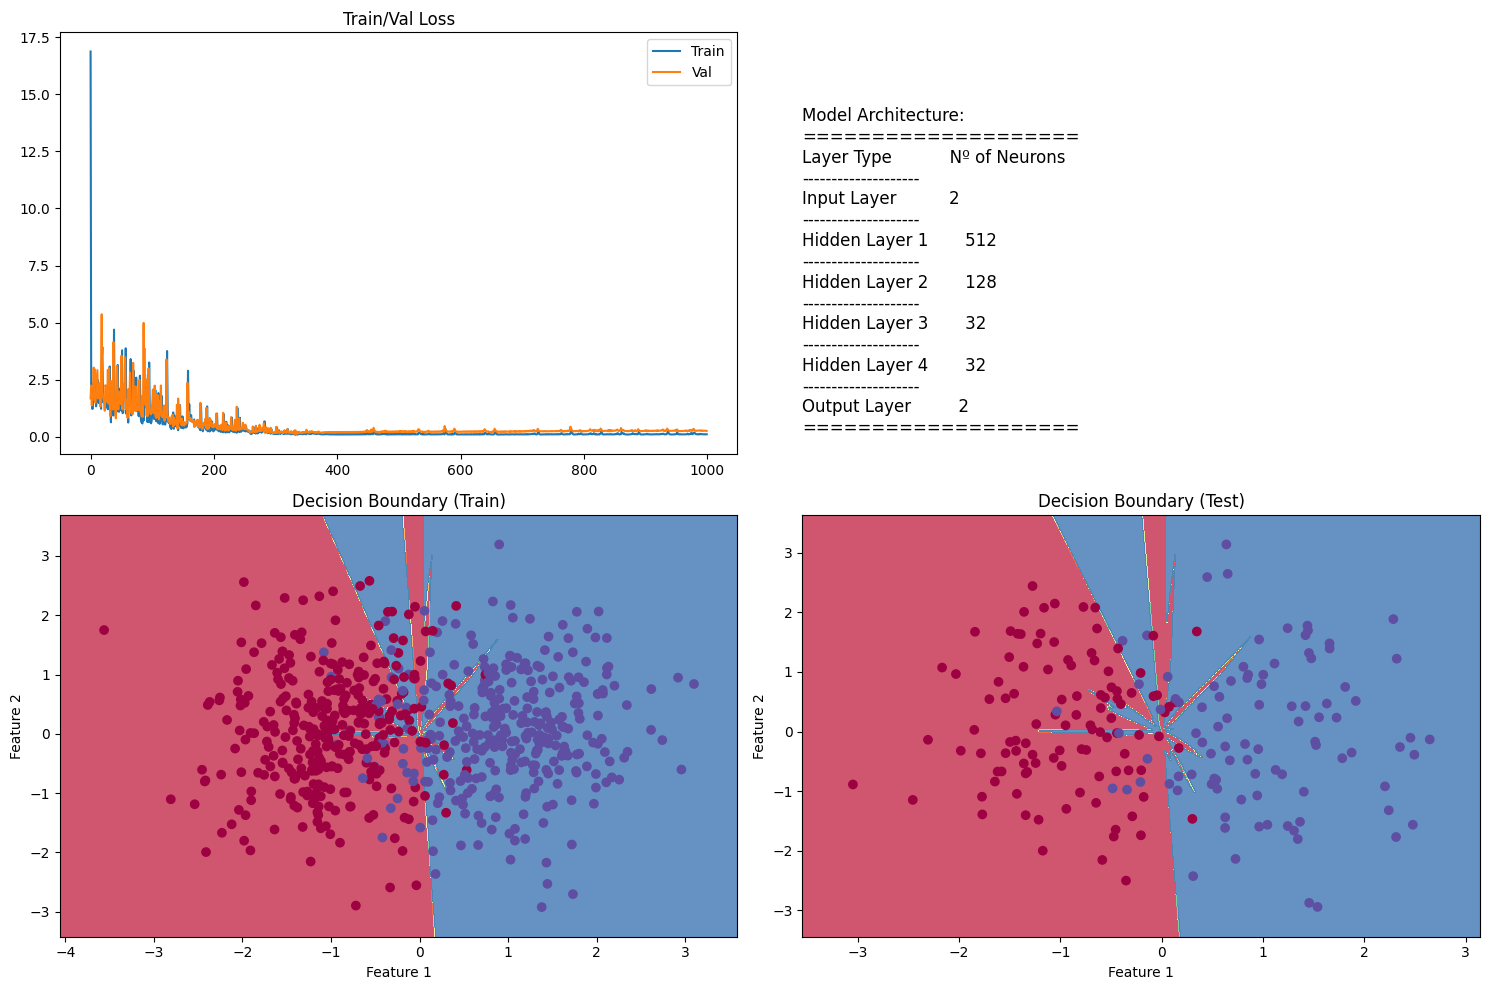

In [ ]:
#@title Plot results

accuracy = []
xx_train, yy_train = [], []
xx_test, yy_test = [], []
Z_train, Z_test = [], []

accuracy.append(evaluate_accuracy(nn, x_test, y_test))
print("Accuracy:", accuracy[0])

# Plot results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(range(nn.epochs), nn.losses)
axes[0, 0].plot(range(nn.epochs), nn.val_losses)
axes[0, 0].set_title("Train/Val Loss")
axes[0, 0].legend(['Train', 'Val'])

# Show summary
axes[0, 1].axis('off')
axes[0, 1].text(0, 0, summary(nn), fontsize=12)

xx_aux, yy_aux, Z_aux = plot_decision_boundary(nn, x_train)
xx_train.append(xx_aux)
yy_train.append(yy_aux)
Z_train.append(Z_aux)
axes[1, 0].contourf(xx_train[0], yy_train[0], Z_train[0], cmap=plt.cm.Spectral, alpha=0.8)
axes[1, 0].scatter(x_train[:, 0], x_train[:, 1], c=np.argmax(y_train, axis=1), cmap=plt.cm.Spectral)
axes[1, 0].set_title("Decision Boundary (Train)")
axes[1, 0].set_xlabel("Feature 1")
axes[1, 0].set_ylabel("Feature 2")

xx_aux, yy_aux, Z_aux = plot_decision_boundary(nn, x_test)
xx_test.append(xx_aux)
yy_test.append(yy_aux)
Z_test.append(Z_aux)
axes[1, 1].contourf(xx_test[0], yy_test[0], Z_test[0], cmap=plt.cm.Spectral, alpha=0.8)
axes[1, 1].scatter(x_test[:, 0], x_test[:, 1], c=np.argmax(y_test, axis=1), cmap=plt.cm.Spectral)
axes[1, 1].set_title("Decision Boundary (Test)")
axes[1, 1].set_xlabel("Feature 1")
axes[1, 1].set_ylabel("Feature 2")

plt.tight_layout()
plt.show()

# **Questions**


1. **How did the model's performance evolve over time?**

The model shows rapid learning in the first 150-200 epochs, significantly reducing both training and validation loss. After 300-400 epochs, the loss converges, indicating the model has reached optimal learning.Training and validation losses remain closely aligned throughout, suggesting good generalization without overfitting.The learning process stabilizes effectively, with minimal noise in the validation loss after convergence. It will be interesting to a more proper graph to see the real difference between train and val loss at the final epochs because in this graph due to the first big values the lines appear very close but with the information that we have we can assume that the performance is good.

# Improving our neural network

Now we are going to implement some techniques to improve the performance of our neural network during training so that it generalizes better before the test data.

# Parameter inizialization

**Xavier Initialization** is a technique designed to address the issue of maintaining a constant variance for activations throughout the layers of a deep neural network. The primary objective is to prevent the gradients from becoming too small or too large, a phenomenon often referred to as the vanishing or exploding gradients problem. This approach is particularly important because if the variance of the activations varies significantly across layers, it can lead to unstable convergence behavior during training.

Unlike random initialization, which draws weights from a zero-mean Gaussian distribution and risks unstable activations, Xavier Initialization uses a uniform distribution bounded by: \

 $$
\pm \frac{\sqrt{6}}{\sqrt{n_i + n_{i+1}}}
$$

where $n_{i}$ and $n_{i+1}$ represent the number of neurons in the adjacent layers. This method promotes stable convergence during training and is particularly beneficial for deep networks, as discussed in [Understanding the difficulty of training deep feedforward neural networks](https://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)

**He Initialization**, also known as He Normal Initialization, is a technique designed for initializing the weights of deep neural networks that use ReLU activation functions. The key idea behind He Initialization is to set the initial weights of the network such that the variance remains the same for both inputs and outputs throughout the network.

$$
  \sqrt{\frac{2}{n_i}}
$$

In [ ]:
import numpy as np

def initialize_parameters(self):
    # Initialize weights and biases
    for i in range(len(self.layer_sizes) - 1):
        n_i = self.layer_sizes[i]
        n_i_next = self.layer_sizes[i + 1]

        if i < len(self.layer_sizes) - 2:  # He initialization for ReLU (all layers except last)
            std_dev = np.sqrt(2 / n_i)  # He initialization
        else:  # Xavier initialization for Sigmoid (last layer)
            std_dev = np.sqrt(1 / n_i)  # Xavier initialization

        # Initialize weights using a normal distribution with mean 0 and std_dev
        self.weights[i] = self.random_state.normal(0, std_dev, (n_i, n_i_next))
        self.biases[i] = np.zeros((1, n_i_next))

# Replace the function in the model
DL_Model.initialize_parameters = initialize_parameters


In [ ]:
nn = DL_Model(learning_rate, epochs, layer_sizes)
nn.fit(x_train, y_train, validation_data=(x_val, y_val))

Epoch:1000, Loss:0.1029, Val Loss:0.1029

Accuracy: 0.92


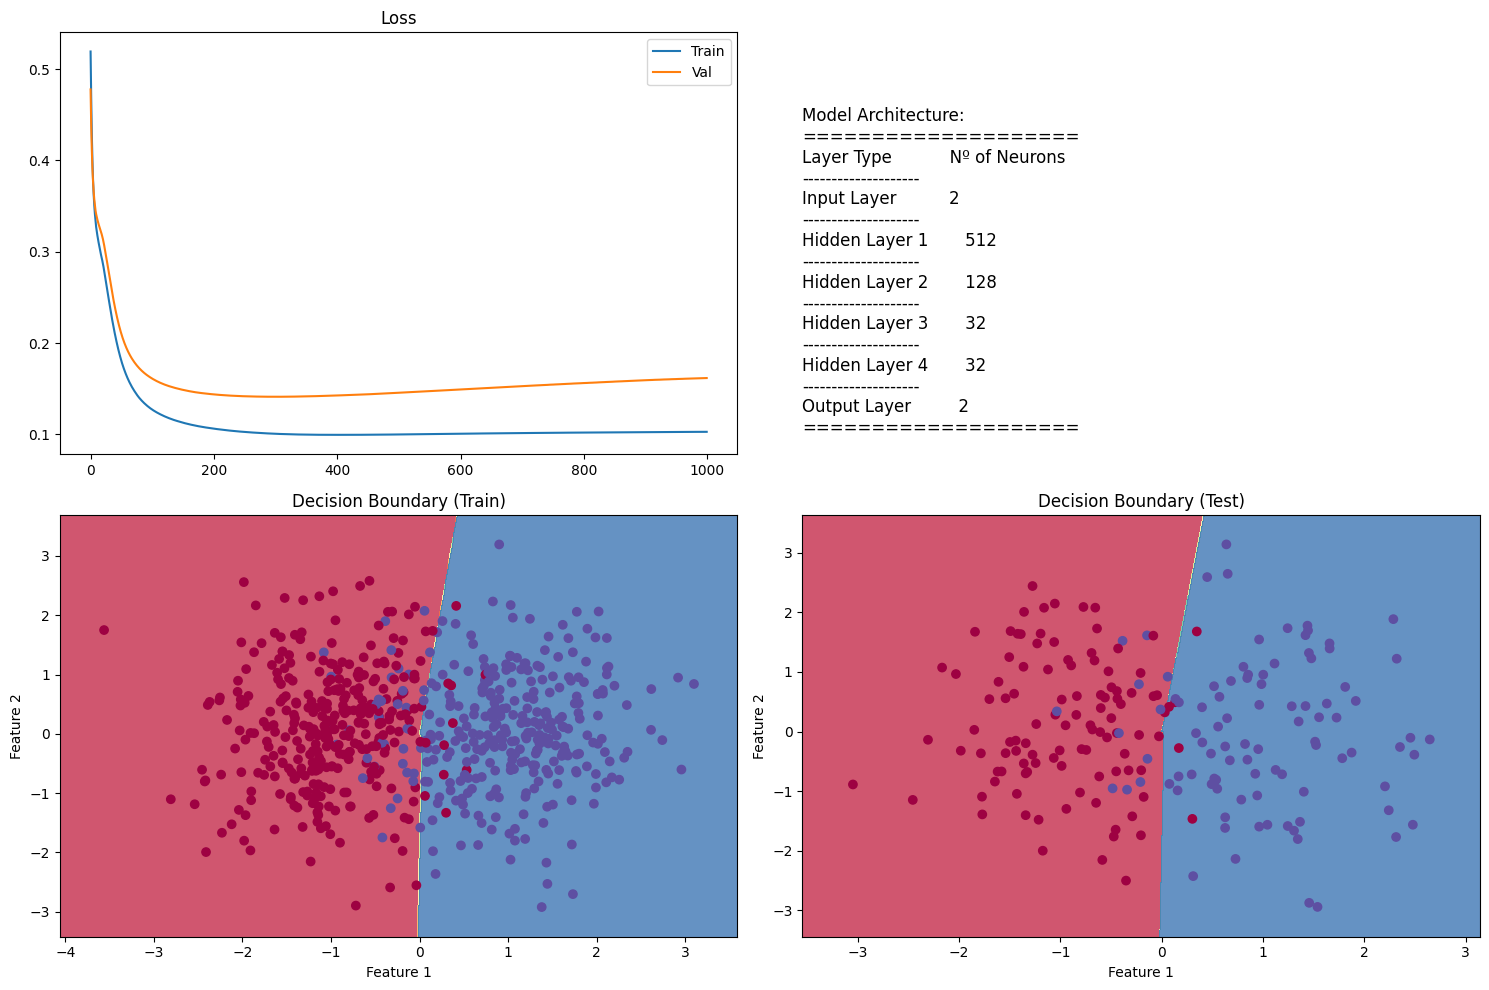

In [ ]:
#@title Plot results

accuracy.append(evaluate_accuracy(nn, x_test, y_test))
print("Accuracy:", accuracy[1])

# Plot results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(range(nn.epochs), nn.losses)
axes[0, 0].plot(range(nn.epochs), nn.val_losses)
axes[0, 0].set_title("Loss")
axes[0, 0].legend(['Train', 'Val'])

# Show summary
axes[0, 1].axis('off')
axes[0, 1].text(0, 0, summary(nn), fontsize=12)

xx_aux, yy_aux, Z_aux = plot_decision_boundary(nn, x_train)
xx_train.append(xx_aux)
yy_train.append(yy_aux)
Z_train.append(Z_aux)
axes[1, 0].contourf(xx_train[1], yy_train[1], Z_train[1], cmap=plt.cm.Spectral, alpha=0.8)
axes[1, 0].scatter(x_train[:, 0], x_train[:, 1], c=np.argmax(y_train, axis=1), cmap=plt.cm.Spectral)
axes[1, 0].set_title("Decision Boundary (Train)")
axes[1, 0].set_xlabel("Feature 1")
axes[1, 0].set_ylabel("Feature 2")

xx_aux, yy_aux, Z_aux = plot_decision_boundary(nn, x_test)
xx_test.append(xx_aux)
yy_test.append(yy_aux)
Z_test.append(Z_aux)
axes[1, 1].contourf(xx_test[1], yy_test[1], Z_test[1], cmap=plt.cm.Spectral, alpha=0.8)
axes[1, 1].scatter(x_test[:, 0], x_test[:, 1], c=np.argmax(y_test, axis=1), cmap=plt.cm.Spectral)
axes[1, 1].set_title("Decision Boundary (Test)")
axes[1, 1].set_xlabel("Feature 1")
axes[1, 1].set_ylabel("Feature 2")

plt.tight_layout()
plt.show()

# Dropout

We are going to adapt the feed-forward and backpropagation functions in order to apply dropout.

In [ ]:
# Feed forward with dropout
def forward_with_dropout(self, x):
    # Forward pass
    self.activations = {}
    self.activations[0] = x
    self.dropout_masks = {}
    for i in range(len(self.layer_sizes) - 1):
        self.activations[i + 1] = np.dot(self.activations[i], self.weights[i]) + self.biases[i]
        if i != len(self.layer_sizes) - 2:
            self.activations[i + 1] = relu(self.activations[i + 1])
            self.activations[i + 1], self.dropout_masks[i] = self.apply_dropout(self.activations[i + 1])
        else:
            self.activations[i + 1] = sigmoid(self.activations[i + 1])

def backward_with_dropout(self, y):
    # Backward pass
    self.gradients = {}
    loss_derivative = loss_function_derivative(y, self.activations[len(self.layer_sizes) - 1])
    self.gradients[len(self.layer_sizes) - 2] = loss_derivative
    for i in range(len(self.layer_sizes) - 2, 0, -1):
        self.gradients[i - 1] = np.dot(self.gradients[i], self.weights[i].T) * relu_derivative(self.activations[i])
        self.gradients[i - 1] *= self.dropout_masks[i - 1]

DL_Model.feed_forward = forward_with_dropout
DL_Model.backpropagation = backward_with_dropout

Implementing dropout will help in preventing overfitting by randomly disabling a subset of neurons during each training iteration, thus forcing the network to learn more robust features that are not reliant on any specific set of neurons. This technique often results in a more generalized model with better performance on unseen data.



In [ ]:

def apply_dropout(self, a):
    # Generate a random matrix D with the same shape as the input activations (a).
    # Each element of D is drawn from a uniform distribution over [0, 1).
    # Note: use self.random_state to generate randoms
    D = self.random_state.uniform(0, 1, a.shape)

    # Create a dropout mask by setting elements of D to 1 if they are less than
    # the dropout probability (self.dropout_prob), else to 0.
    # This mask will randomly "drop" a portion of the activations.
    dropout_mask = (D > self.dropout_prob).astype(int)

    # Apply the dropout mask to the activations (a).
    # This sets a subset of a's elements to zero, effectively "dropping" them.
    a_dropped = a * dropout_mask

    # To compensate for the reduced number of active neurons, we scale up the remaining activations.
    # This is done to maintain the expected sum of activations, which is important for
    # not altering the behavior of the layer during inference.
    a_scaled = a_dropped / (1 - self.dropout_prob)

    return a_scaled, dropout_mask

# Replace the function in the model
DL_Model.apply_dropout = apply_dropout


In [ ]:
# Ahora entrena la red con el dropout implentado
nn = DL_Model(learning_rate, epochs, layer_sizes, dropout_prob=0.1)
nn.fit(x_train, y_train, validation_data=(x_val, y_val))

Epoch:1000, Loss:0.1029, Val Loss:0.1029

Accuracy: 0.92


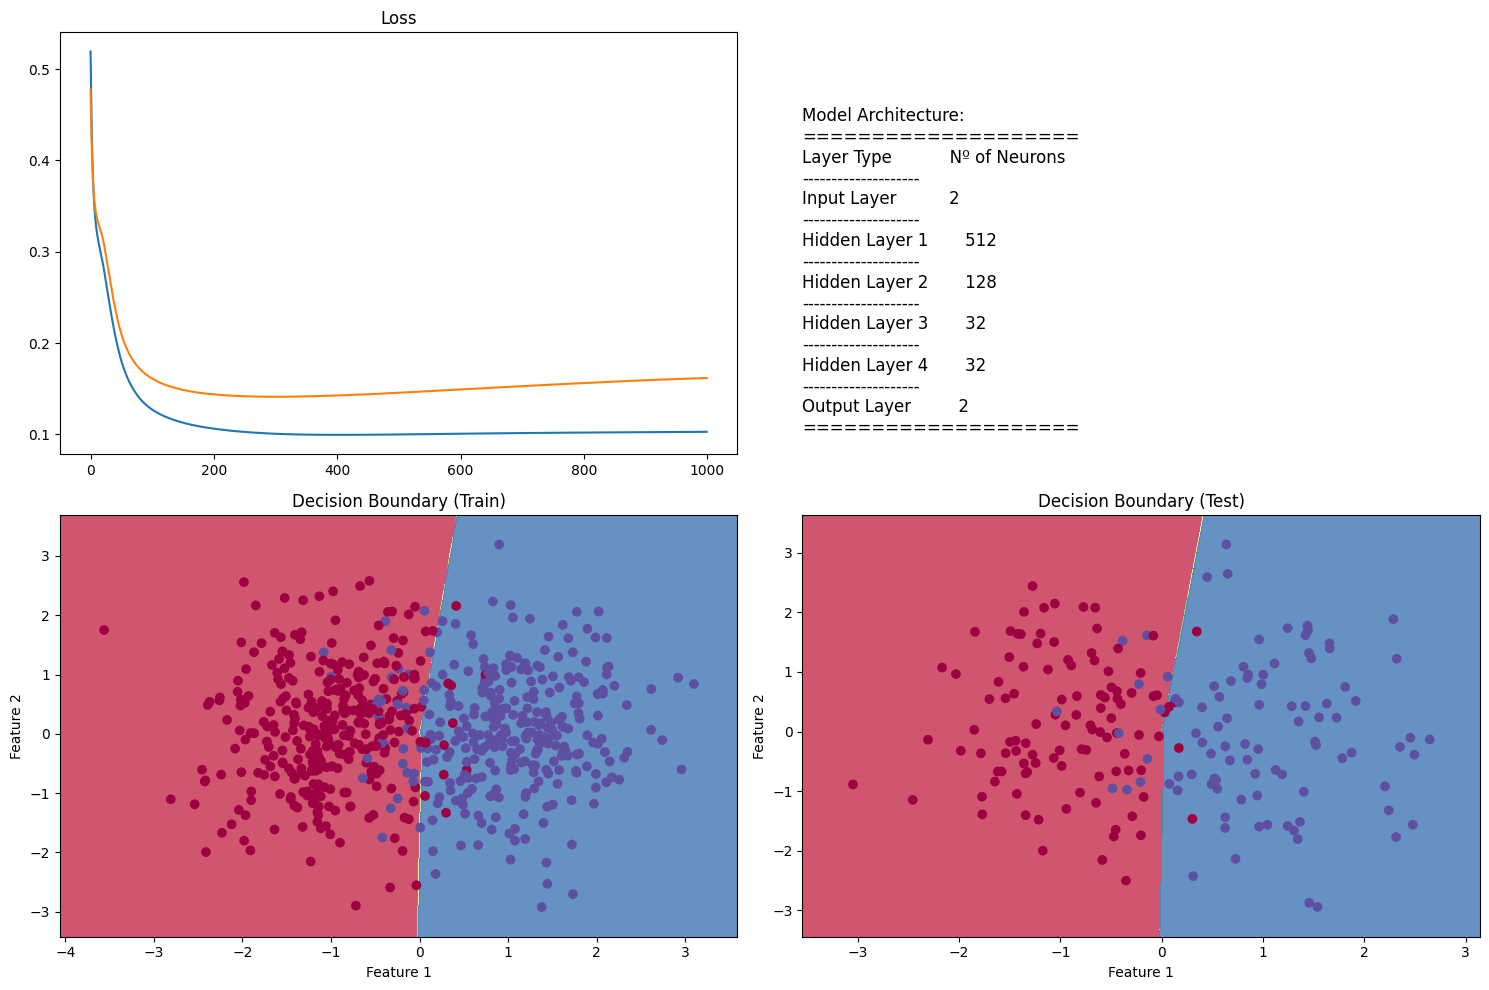

In [ ]:
#@title Plot results

accuracy.append(evaluate_accuracy(nn, x_test, y_test))
print("Accuracy:", accuracy[2])

# Plot results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(range(nn.epochs), nn.losses)
axes[0, 0].plot(range(nn.epochs), nn.val_losses)
axes[0, 0].set_title("Loss")

# Show summary
axes[0, 1].axis('off')
axes[0, 1].text(0, 0, summary(nn), fontsize=12)

xx_aux, yy_aux, Z_aux = plot_decision_boundary(nn, x_train)
xx_train.append(xx_aux)
yy_train.append(yy_aux)
Z_train.append(Z_aux)
axes[1, 0].contourf(xx_train[2], yy_train[2], Z_train[2], cmap=plt.cm.Spectral, alpha=0.8)
axes[1, 0].scatter(x_train[:, 0], x_train[:, 1], c=np.argmax(y_train, axis=1), cmap=plt.cm.Spectral)
axes[1, 0].set_title("Decision Boundary (Train)")
axes[1, 0].set_xlabel("Feature 1")
axes[1, 0].set_ylabel("Feature 2")

xx_aux, yy_aux, Z_aux = plot_decision_boundary(nn, x_test)
xx_test.append(xx_aux)
yy_test.append(yy_aux)
Z_test.append(Z_aux)
axes[1, 1].contourf(xx_test[2], yy_test[2], Z_test[2], cmap=plt.cm.Spectral, alpha=0.8)
axes[1, 1].scatter(x_test[:, 0], x_test[:, 1], c=np.argmax(y_test, axis=1), cmap=plt.cm.Spectral)
axes[1, 1].set_title("Decision Boundary (Test)")
axes[1, 1].set_xlabel("Feature 1")
axes[1, 1].set_ylabel("Feature 2")

plt.tight_layout()
plt.show()

# Early Stopping

Based on our results, we can estimate that after 2500 epochs, our model stats overfitting to the training set.

Early stopping halts the training process once the model’s performance on a validation set starts to deteriorate, thereby preventing the model from learning noise and irrelevant patterns in the training data. By stopping the training early, it saves computational resources and time, as the model no longer processes through unnecessary epochs of training that don’t improve generalization.

In [ ]:

def fit(self, x, y, batch_size=32, validation_data=None, patience=10):
    self.initialize_parameters()

    best_loss = float('inf')  # Inicializamos la mejor pérdida como infinito
    epochs_without_improvement = 0  # Contador de épocas sin mejora

    self.losses = []  # Lista para almacenar la pérdida en entrenamiento
    self.val_losses = []  # Lista para almacenar la pérdida en validación

    for epoch in range(self.epochs):
        # Forward propagation
        self.forward(x)

        # Backward propagation
        self.backward(y)

        # Update parameters
        self.update_parameters()

        # Compute training loss
        train_loss = loss_function(y, self.activations[len(self.layer_sizes) - 1])
        self.losses.append(train_loss)

        # Early stopping - Check validation loss
        if validation_data is not None:
            x_val, y_val = validation_data  # Extraemos datos de validación

            # Forward pass con datos de validación
            self.forward(x_val)

            # Calcular pérdida de validación
            val_loss = loss_function(y_val, self.activations[len(self.layer_sizes) - 1])
            self.val_losses.append(val_loss)

            # Comprobamos si la pérdida de validación mejora
            if val_loss < best_loss:
                best_loss = val_loss  # Actualizamos la mejor pérdida
                epochs_without_improvement = 0  # Reiniciamos el contador
            else:
                epochs_without_improvement += 1  # Aumentamos el contador

            # Si no hay mejora en "patience" épocas, detenemos el entrenamiento
            if epochs_without_improvement >= patience:
                print(f"\nEarly Stopping triggered after {epoch + 1} epochs.")
                break
        else:
            self.val_losses.append(None)  # Si no hay validación, no almacenamos pérdidas

        # Imprimir progreso
        val_loss_str = f"{self.val_losses[-1]:.4f}" if validation_data is not None else "N/A"
        print(f"\rEpoch: {epoch + 1}, Loss: {train_loss:.4f}, Val Loss: {val_loss_str}", end="")

# Replace the function in the model
DL_Model.fit = fit


In [ ]:
nn = DL_Model(learning_rate, epochs, layer_sizes, dropout_prob=0.5)
nn.fit(x_train, y_train, validation_data=(x_val, y_val), patience=15)

Epoch: 316, Loss: 0.1004, Val Loss: 0.1413
Early Stopping triggered after 317 epochs.


Accuracy: 0.92


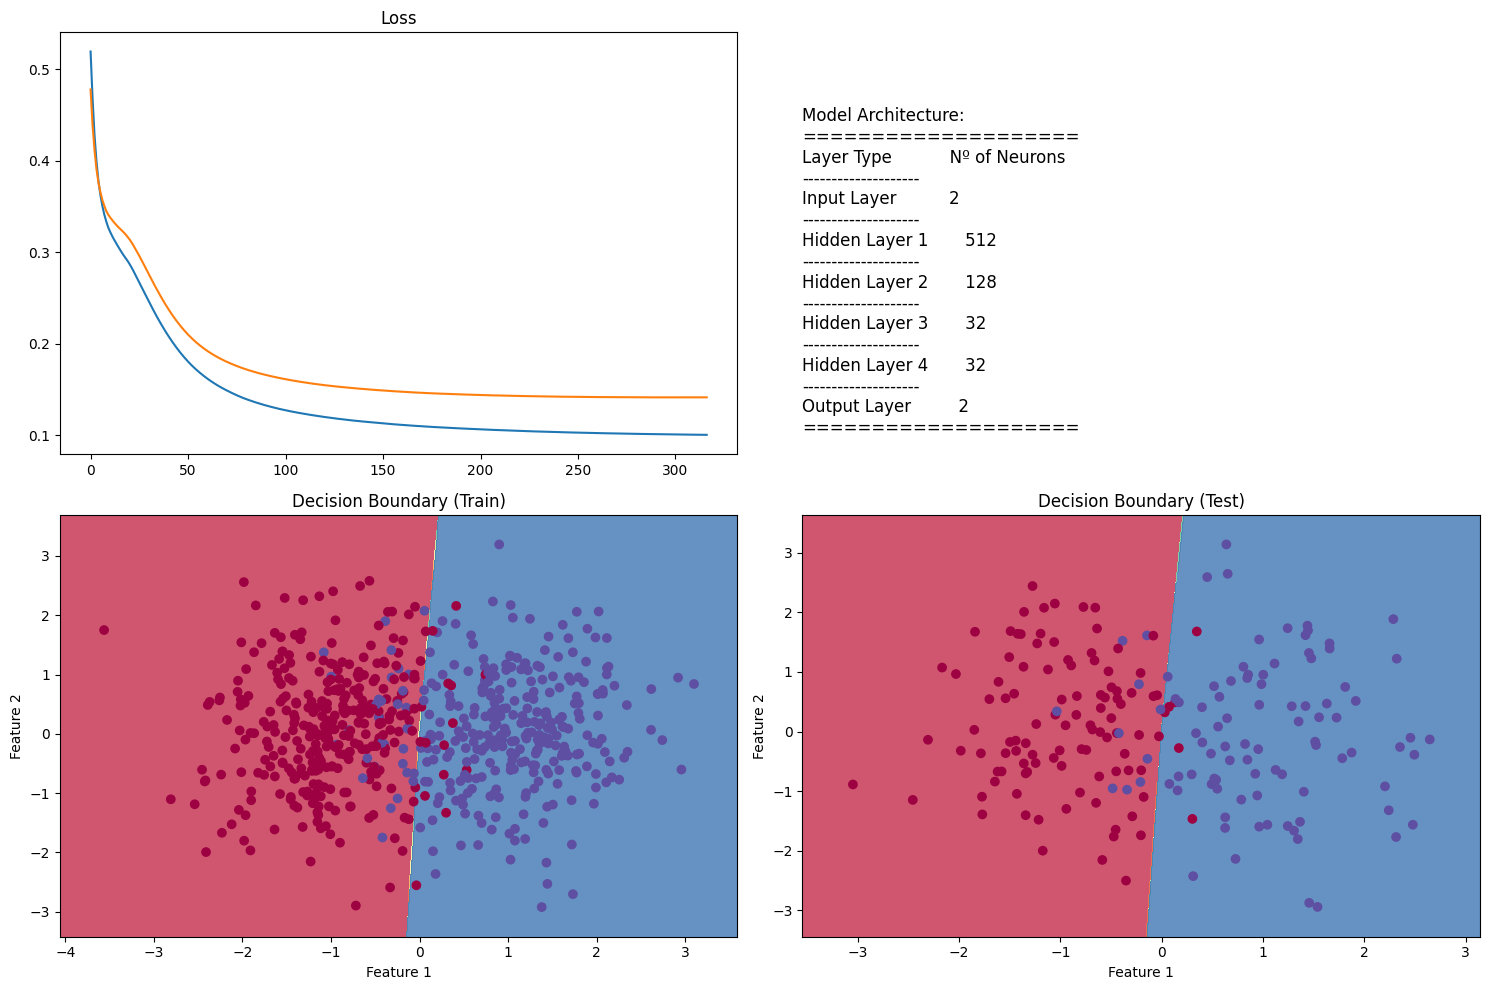

In [ ]:
#@title Plot results

accuracy.append(evaluate_accuracy(nn, x_test, y_test))
print("Accuracy:", accuracy[3])

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(range(len(nn.losses)), nn.losses)
axes[0, 0].plot(range(len(nn.val_losses)), nn.val_losses)
axes[0, 0].set_title("Loss")

axes[0, 1].axis('off')
axes[0, 1].text(0, 0, summary(nn), fontsize=12)

xx_aux, yy_aux, Z_aux = plot_decision_boundary(nn, x_train)
xx_train.append(xx_aux)
yy_train.append(yy_aux)
Z_train.append(Z_aux)
axes[1, 0].contourf(xx_train[3], yy_train[3], Z_train[3], cmap=plt.cm.Spectral, alpha=0.8)
axes[1, 0].scatter(x_train[:, 0], x_train[:, 1], c=np.argmax(y_train, axis=1), cmap=plt.cm.Spectral)
axes[1, 0].set_title("Decision Boundary (Train)")
axes[1, 0].set_xlabel("Feature 1")
axes[1, 0].set_ylabel("Feature 2")

xx_aux, yy_aux, Z_aux = plot_decision_boundary(nn, x_test)
xx_test.append(xx_aux)
yy_test.append(yy_aux)
Z_test.append(Z_aux)
axes[1, 1].contourf(xx_test[3], yy_test[3], Z_test[3], cmap=plt.cm.Spectral, alpha=0.8)
axes[1, 1].scatter(x_test[:, 0], x_test[:, 1], c=np.argmax(y_test, axis=1), cmap=plt.cm.Spectral)
axes[1, 1].set_title("Decision Boundary (Test)")
axes[1, 1].set_xlabel("Feature 1")
axes[1, 1].set_ylabel("Feature 2")

plt.tight_layout()
plt.show()

# **Questions**

1. **What other regularization techniques do you know? Comment them**

1️ L1 Regularization (Lasso) – Encourages sparsity by adding the absolute values of weights as a penalty, leading to feature selection.

2️ L2 Regularization (Ridge, Weight Decay) – Prevents large weights by adding the squared values of weights as a penalty, improving generalization.

3️ Batch Normalization (BatchNorm) – Normalizes activations across a mini-batch, speeding up training and reducing internal covariate shift.

4️ Data Augmentation – Artificially increases dataset size with transformations like rotations, cropping, and noise to improve generalization.